In [ ]:
%load_ext autoreload
%autoreload 2

import batman
import gpjax as gpx
import jax.numpy as jnp
from jax import jit
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from gpjax.kernels import RBF, Constant, Linear, Periodic, PoweredExponential

from kernels import OrnsteinUhlenbeck, ProductKernel, SumKernel
from kernelsearch import KernelSearch

import emcee

rng = np.random.default_rng(seed=42)

In [ ]:
plt.style.use(
    "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
)
cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

In [ ]:
def calculate_lightcurve(t, params):
    param_container = batman.TransitParams()
    param_container.t0 = params[0]  # time of inferior conjunction
    param_container.per = 1.0  # orbital period
    param_container.rp = params[1]  # planet radius (in units of stellar radii)
    param_container.a = params[2]  # semi-major axis (in units of stellar radii)
    param_container.inc = 87.0  # orbital inclination (in degrees)
    param_container.ecc = 0.0  # eccentricity
    param_container.w = 90.0  # longitude of periastron (in degrees)
    param_container.u = [params[3], params[4]]  # limb darkening coefficients [u1, u2]
    param_container.limb_dark = "quadratic"  # limb darkening model

    m = batman.TransitModel(param_container, t)  # initializes model
    return m.light_curve(param_container)

In [ ]:
t = np.linspace(-0.05, 0.08, 1000)
true_lightcurve = calculate_lightcurve(
    t=t,
    params=[0, 0.1, 15, 0.1, 0.3],
)

In [ ]:
test_ind = np.sort(rng.choice(len(t), 150))
t_train = t[test_ind]
lc_latent = (
    true_lightcurve
    - 0.05 * np.cos(200 * t / (2 * np.pi))
    + 0.08 * (((t - 0.01) / t[-1]) ** 2) * np.sin(4000 * t / (2 * np.pi))
)
lc_train = lc_latent[test_ind] + rng.normal(scale=0.005, size=len(test_ind))

In [ ]:
mask = ~np.ma.masked_where((-0.01 < t_train) & (t_train < 0.01), t_train).mask

In [ ]:
# plt.plot(t, true_lightcurve)
plt.scatter(t_train, lc_train)

In [ ]:
from kernelsearch import KernelSearch
from kernels import OrnsteinUhlenbeck
from gpjax.kernels import RBF, Linear, Periodic, PoweredExponential

In [ ]:
kernel_library = [
    Linear(),
    RBF(),
    OrnsteinUhlenbeck(),
    Periodic(),
    # PoweredExponential(power=jnp.array(0.5)),
]  # default powered exponential has infinite parameter for some reason

In [ ]:
tree = KernelSearch(
    kernel_library,
    X=jnp.array(t_train[mask]),
    y=jnp.array(lc_train[mask]),
    obs_stddev=0.005,
    verbosity=1,
)

model = tree.search(
    depth=7,
    n_leafs=3,
    patience=1,
)

In [ ]:
model.describe_kernel()

In [ ]:
latent_dist = model.posterior(t.reshape(-1, 1), train_data=tree.data)
predictive_dist = model.posterior.likelihood(latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

In [ ]:
fig, ax = plt.subplots(figsize=(7.5, 2.5))
ax.scatter(t_train, lc_train, label="Observations", color=cols[0], alpha=0.5)
ax.fill_between(
    t,
    predictive_mean - 2 * predictive_std,
    predictive_mean + 2 * predictive_std,
    alpha=0.2,
    label="Two sigma",
    color=cols[1],
)
ax.plot(
    t,
    predictive_mean - 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    t,
    predictive_mean + 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    t,
    lc_latent,
    label="Latent function",
    color=cols[0],
    linestyle="--",
    linewidth=2,
)
ax.plot(t, predictive_mean, label="Predictive mean", color=cols[1])
ax.legend(loc="center left", bbox_to_anchor=(0.975, 0.5))

## TEST MCMC

In [ ]:
from multiprocessing import Pool

In [98]:
def log_likelihood(
    params,
    lc_model,
    gp_model,
    X,
    y,
    mask,
):
    gp_posterior = gp_model.update_trainables(
        params[: gp_model.n_parameter],
        unconstrain=True,
    )

    latent_dist = gp_posterior(
        X.reshape(-1, 1),
        train_data=gpx.Dataset(X=X[mask].reshape(-1, 1), y=y[mask].reshape(-1, 1)),
    )
    predictive_dist = gp_posterior.likelihood(
        latent_dist
    )  # adds observational uncertainty

    lightcurve = jnp.array(lc_model(X, params[gp_model.n_parameter :]))
    if not jnp.isfinite(lightcurve).all():
        return -jnp.inf

    return predictive_dist.log_prob(y - lightcurve)

In [ ]:
# def lc_param_prior(lc_params):

In [102]:
def run_mcmc(
    lc_model,
    gp_model,
    X,
    y,
    mask,
    lc_initial_params,
    nwalker=32,
    parallel=False,
):
    gp_initial_params = gp_model.get_trainables(unconstrain=True)

    initial_params = jnp.concatenate(
        [gp_initial_params, jnp.asarray(lc_initial_params)]
    )
    ndim = len(initial_params)

    initial_pos = initial_params + (
        1e-2 * jnp.median(initial_params) * np.random.randn(nwalker, ndim)
    )

    if parallel:
        with Pool() as pool:
            sampler = emcee.EnsembleSampler(
                nwalker,
                ndim,
                log_likelihood,
                args=(
                    lc_model,
                    gp_model,
                    X,
                    y,
                    mask,
                ),
                pool=pool,
            )
            for sample in sampler.sample(initial_pos, iterations=5, progress=True):
                # Only check convergence every 100 steps
                if sampler.iteration % 10:
                    print(sampler.iteration)
            # sampler.run_mcmc(initial_pos, 2000, progress=True)
    else:
        sampler = emcee.EnsembleSampler(
            nwalker,
            ndim,
            log_likelihood,
            args=(
                lc_model,
                gp_model,
                X,
                y,
                mask,
            ),
        )
        sampler.run_mcmc(initial_pos, 2000, progress=True)
    return sampler

In [103]:
test = run_mcmc(
    calculate_lightcurve,
    model,
    t_train,
    lc_train,
    mask,
    [0.3, 0, 20, 0.2, 0.1],
    parallel=True,
)

KeyboardInterrupt: 

(-1.2, 1.2)

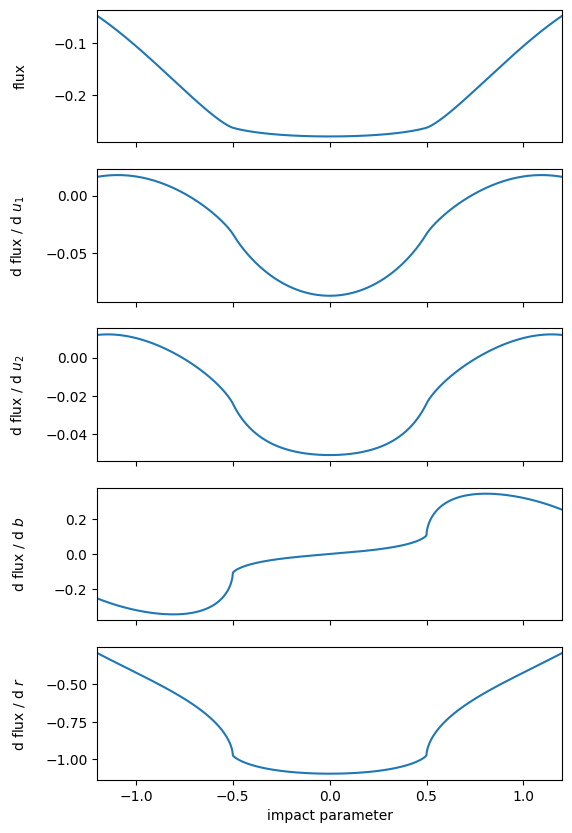

In [4]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jaxoplanet.core.limb_dark import light_curve

lc = lambda u1, u2, b, r: light_curve(jnp.array([u1, u2]), b, r)
b = jnp.linspace(-1.2, 1.2, 1001)
r = 0.5
u1, u2 = 0.2, 0.3

_, axes = plt.subplots(5, 1, figsize=(6, 10), sharex=True)

axes[0].plot(b, lc(u1, u2, b, r))
axes[0].set_ylabel("flux")
axes[0].yaxis.set_label_coords(-0.15, 0.5)
for n, name in enumerate(["$u_1$", "$u_2$", "$b$", "$r$"]):
    axes[n + 1].plot(
        b,
        jax.vmap(jax.grad(lc, argnums=n), in_axes=(None, None, 0, None))(u1, u2, b, r),
    )
    axes[n + 1].set_ylabel(f"d flux / d {name}")
    axes[n + 1].yaxis.set_label_coords(-0.15, 0.5)
axes[-1].set_xlabel("impact parameter")
axes[-1].set_xlim(-1.2, 1.2)